In [2]:
!pip install monai

     |████████████████████████████████| 584 kB 812 kB/s eta 0:00:01


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import monai
from monai.transforms import Compose, Resize, ScaleIntensity, ToTensor, RandAffine, ResizeWithPadOrCrop, apply_transform, RandFlip

In [5]:
from monai.networks.nets import EfficientNetBN

In [6]:
import pydicom
import matplotlib.pyplot as plt
import os

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [9]:
from tqdm.notebook import tqdm

In [10]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_planes = pd.read_csv("../input/train-cleanedcsv/train_cleaned.csv", index_col=0)

In [11]:
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [12]:
train_planes

,patient,modality,plane,image_id,has_image,train_or_test,path,has_tumor
0,87,T1w,axial,14,1,train,/Users/victor/Desktop/deep_learning/project/br...,1
1,53,FLAIR,axial,464,1,train,/Users/victor/Desktop/deep_learning/project/br...,0
2,28,T2w,sagittal,294,1,train,/Users/victor/Desktop/deep_learning/project/br...,1
3,6,T2w,sagittal,64,0,train,/Users/victor/Desktop/deep_learning/project/br...,1
4,478,T1wCE,axial,130,1,train,/Users/victor/Desktop/deep_learning/project/br...,1
...,...,...,...,...,...,...,...,...
348636,387,T1w,axial,83,1,train,/Users/victor/Desktop/deep_learning/project/br...,0
348637,674,T1wCE,axial,79,1,train,/Users/victor/Desktop/deep_learning/project/br...,1
348638,100,FLAIR,axial,10,1,train,/Users/victor/Desktop/deep_learning/project/br...,1
348639,760,T1w,axial,6,0,train,/Users/victor/Desktop/deep_learning/project/br...,1


In [13]:
train_df["BraTS21ID_filled"] = train_df.BraTS21ID.astype(str).str.zfill(5)

In [14]:
train_df

,BraTS21ID,MGMT_value,BraTS21ID_filled
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [15]:
!mkdir ./resized_cropped

In [16]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [17]:
resizer = Resize((-1,224,224))
padder = ResizeWithPadOrCrop((50,224,224))
unable_to_process = []

for (patient,filled) in tqdm(train_df[["BraTS21ID", "BraTS21ID_filled"]].values):
    try:
        img_nums = train_planes[(train_planes.patient == patient) & (train_planes.modality == "T1w") & (train_planes.plane == "axial")]["image_id"].sort_values().values
        patient_x = np.array([load_dicom(f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{filled}/T1w/Image-{num}.dcm") for num in img_nums])
        h,w,d = patient_x.shape
        patient_x = patient_x.reshape((-1, h, w, d))
        resized = resizer(patient_x)
        padded = padder(resized)
        np.save(f"./resized_cropped/patient_{patient}.npy", padded)
    except:
        print(f"Couldn't process patient {patient}")
        unable_to_process.append(patient)

  0%|          | 0/585 [00:00<?, ?it/s]

Couldn't process patient 70
Couldn't process patient 351
Couldn't process patient 353
Couldn't process patient 445
Couldn't process patient 539
Couldn't process patient 556
Couldn't process patient 568
Couldn't process patient 572
Couldn't process patient 578
Couldn't process patient 581
Couldn't process patient 584
Couldn't process patient 587
Couldn't process patient 589
Couldn't process patient 593
Couldn't process patient 594
Couldn't process patient 596
Couldn't process patient 610
Couldn't process patient 756


In [18]:
resized_train = train_df[~train_df.BraTS21ID.isin(unable_to_process)]
resized_train

,BraTS21ID,MGMT_value,BraTS21ID_filled
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [19]:
resized_train

,BraTS21ID,MGMT_value,BraTS21ID_filled
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [20]:
#train_final, valid_final = train_test_split(resized_train, test_size=0.2, stratify=resized_train['MGMT_value'], random_state=2021)

In [21]:
train_final = resized_train.copy()

In [22]:
class PatientDataset3D(Dataset):
    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]   

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_dir = f"./resized_cropped/patient_{row['BraTS21ID']}.npy" 
        img = np.load(img_dir)

        if self.transform is not None:
            img = apply_transform(self.transform, img)

        if self.mode == 'test':
            return img
        else:
            return img, torch.tensor(row['MGMT_value']).float()

In [23]:
train_transform = Compose([ScaleIntensity(),
                           RandFlip(),
                           RandAffine( 
                                      prob= 0.5,
                                      translate_range=(1, 5, 5),
                                      rotate_range=(0.2, 0.2, 0.2), 
                                      scale_range=(0, 0.2, 0.2),
                                      padding_mode="border"),
                           ToTensor()])

val_transform = Compose([ScaleIntensity(), ToTensor()])

In [24]:
train_ds = PatientDataset3D(train_final, mode='train', transform=train_transform)
#valid_ds = PatientDataset3D(valid_final, mode='train', transform=val_transform)

In [25]:
next(iter(train_ds))[0].shape

torch.Size([1, 50, 224, 224])

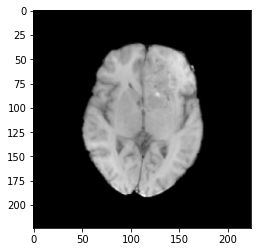

In [26]:
plt.imshow(next(iter(train_ds))[0][0][24], cmap='gray')

In [27]:
train_dl = DataLoader(train_ds, batch_size=8)
#valid_dl = DataLoader(train_ds, batch_size=8, shuffle=False)

In [28]:
imgs, labels = next(iter(train_dl))

In [29]:
imgs.shape, labels

(torch.Size([8, 1, 50, 224, 224]), tensor([1., 1., 0., 1., 1., 1., 0., 1.]))

In [30]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')
device

device(type='cuda', index=0)

In [31]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        y_pred = torch.sigmoid(y_pred).squeeze()
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
        
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        y_pred = torch.sigmoid(y_pred).squeeze()
        y_pred = (y_pred > 0.5).int()
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [32]:
model = EfficientNetBN("efficientnet-b0", pretrained=False, spatial_dims=3, in_channels=1, num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFun = nn.BCELoss()

Skipping loading pretrained weights for non-default efficientnet-b0, pretrained=False, is_default_model=False


In [33]:
model.to(device)

EfficientNetBN(
  (_conv_stem): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False)
  (_conv_stem_padding): ConstantPad3d(padding=[0, 1, 0, 1, 0, 1], value=0.0)
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): MBConvBlock(
      (_expand_conv): Identity()
      (_expand_conv_padding): Identity()
      (_bn0): Identity()
      (_depthwise_conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), groups=32, bias=False)
      (_depthwise_conv_padding): ConstantPad3d(padding=[1, 1, 1, 1, 1, 1], value=0.0)
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_adaptpool): AdaptiveAvgPool3d(output_size=1)
      (_se_reduce): Conv3d(32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (_se_reduce_padding): Identity()
      (_se_expand): Conv3d(8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (_se_expand_padding

In [34]:
num_epochs = 10
train_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
        
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    print('Train Acc: ', train_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  44.65246663295047
Train Acc:  0.5291005291005291
Epoch:  1


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  47.521094308772554
Train Acc:  0.5291005291005291
Epoch:  2


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  23.438433072936366
Train Acc:  0.47089947089947093
Epoch:  3


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  13.644126835843208
Train Acc:  0.47089947089947093
Epoch:  4


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  9.082016472665357
Train Acc:  0.5291005291005291
Epoch:  5


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  7.11871782910656
Train Acc:  0.5379188712522046
Epoch:  6


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  6.04854974696334
Train Acc:  0.49382716049382713
Epoch:  7


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  6.170274350005136
Train Acc:  0.48324514991181655
Epoch:  8


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  6.342314365044446
Train Acc:  0.4744268077601411
Epoch:  9


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss:  6.711480766534805
Train Acc:  0.5291005291005291
